In [ ]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных
from sklearn.model_selection import train_test_split

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

# Предсказание цен машин с Юлы

In [ ]:
# Считываем csv с помощью pandas
cars = pd.read_csv('cars_new.csv', sep=',')
cars[:5] # Выводим первые 5 машин 

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [ ]:
print(cars.values.shape)

(70119, 10)


In [ ]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [ ]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [ ]:
print(marks_dict)

{'hyundai': 0, 'skoda': 1, 'kia': 2, 'renault': 3, 'peugeot': 4, 'mitsubishi': 5, 'ford': 6, 'suzuki': 7, 'daewoo': 8, 'mazda': 9, 'volkswagen': 10, 'mercedes-benz': 11, 'bmw': 12, 'nissan': 13, 'chery': 14, 'opel': 15, 'honda': 16, 'audi': 17, 'subaru': 18, 'chevrolet': 19, 'toyota': 20}


In [ ]:
years.mean()

7.129646144783743e-15

In [ ]:
years.std()

1.0

In [ ]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [ ]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [ ]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          0.          0.          1.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          1.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [ ]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [ ]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [ ]:
y_train_scaled.shape

(70119,)

In [ ]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x_train, y_train_scaled, test_size=0.1, shuffle = True)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size = 0.2, shuffle=True)
print(xTrain.shape)
print(xVal.shape)
print(xTest.shape)
print(yTrain.shape)
print(yVal.shape)
print(yTest.shape)

(50485, 3208)
(12622, 3208)
(7012, 3208)
(50485,)
(12622,)
(7012,)


In [ ]:
yTrain.min()

-0.8204950196272253

In [ ]:
yTrain.max()

38.436834251852716

In [ ]:
model = Sequential()

model.add(Dense(32, input_dim=xTrain.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,  activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=Adam(0.01))

In [ ]:
history = model.fit(xTrain, yTrain, batch_size=2048, epochs=30, validation_data=(xVal, yVal), verbose=1)

Epoch 1/30
25/25 [==============================] - 1s 23ms/step - loss: 0.4419 - val_loss: 0.2481
Epoch 2/30
25/25 [==============================] - 1s 25ms/step - loss: 0.2558 - val_loss: 0.1797
Epoch 3/30
25/25 [==============================] - 1s 24ms/step - loss: 0.2128 - val_loss: 0.1545
Epoch 4/30
25/25 [==============================] - 1s 21ms/step - loss: 0.1838 - val_loss: 0.1365
Epoch 5/30
25/25 [==============================] - 0s 20ms/step - loss: 0.1697 - val_loss: 0.1286
Epoch 6/30
25/25 [==============================] - 1s 21ms/step - loss: 0.1597 - val_loss: 0.1220
Epoch 7/30
25/25 [==============================] - 0s 20ms/step - loss: 0.1619 - val_loss: 0.1212
Epoch 8/30
25/25 [==============================] - 0s 20ms/step - loss: 0.1468 - val_loss: 0.1071
Epoch 9/30
25/25 [==============================] - 1s 22ms/step - loss: 0.1398 - val_loss: 0.1019
Epoch 10/30
25/25 [==============================] - 1s 20ms/step - loss: 0.1373 - val_loss: 0.1049
Epoch 11/

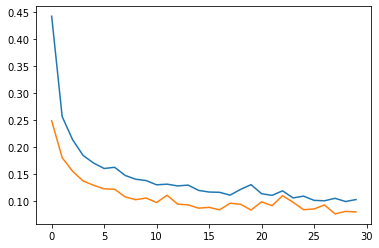

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
model.compile(loss='mse', optimizer=Adam(0.0001))
history = model.fit(xTrain, yTrain, batch_size=1024, epochs=30, validation_data=(xVal, yVal), verbose=1)

Epoch 1/30
50/50 [==============================] - 1s 13ms/step - loss: 0.1000 - val_loss: 0.0741
Epoch 2/30
50/50 [==============================] - 1s 12ms/step - loss: 0.0933 - val_loss: 0.0725
Epoch 3/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0855 - val_loss: 0.0719
Epoch 4/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0889 - val_loss: 0.0704
Epoch 5/30
50/50 [==============================] - 1s 12ms/step - loss: 0.0941 - val_loss: 0.0703
Epoch 6/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0890 - val_loss: 0.0694
Epoch 7/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0832 - val_loss: 0.0691
Epoch 8/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0854 - val_loss: 0.0691
Epoch 9/30
50/50 [==============================] - 1s 13ms/step - loss: 0.0915 - val_loss: 0.0689
Epoch 10/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0867 - val_loss: 0.0690
Epoch 11/

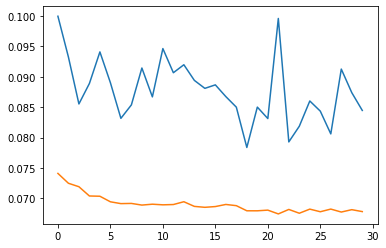

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
model.load_weights('model.h5')

In [ ]:
predict = model.predict(xTest)

In [ ]:
predict_inverse = y_scaler.inverse_transform(predict).flatten()

In [ ]:
yTrainReal = y_scaler.inverse_transform(yTest).flatten()

In [ ]:
yTrainReal[1]

395000.0

In [ ]:
predict_inverse[1]

332740.53

In [ ]:
delta = yTrainReal - predict_inverse
abs_delta = abs(delta)
mean_delta = sum(abs_delta)/len(abs_delta)
mean_price = sum(yTrainReal)/len(yTrainReal)
print("Средняя ошибка: ", round(mean_delta))
print("Средняя цена: ", round(mean_price))
print("Процент ошибки: ", round(100*mean_delta / mean_price), "%", sep="")

Средняя ошибка:  66612.0
Средняя цена:  540870.0
Процент ошибки: 12.0%
